In [1]:
import mlflow
import mlflow.sklearn

## Hospital data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
hospital_data = pd.read_csv('donnees-hospitalieres-covid19/donnees-hospitalieres-covid19-2020-05-01-19h00.csv', sep=';')

In [4]:
hospital_data.head(1)

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0


In [5]:
#paris_data_dep = hospital_data.query('(dep=="75" | dep=="31" | dep=="81" | dep=="92" | dep=="78") & sexe=="0"').sort_values(by='jour')
paris_data_dep = hospital_data.query('dep=="75" & sexe=="0"').sort_values(by='jour')
paris_data_dep['jour'] = paris_data_dep['jour'].str.slice(start=5)

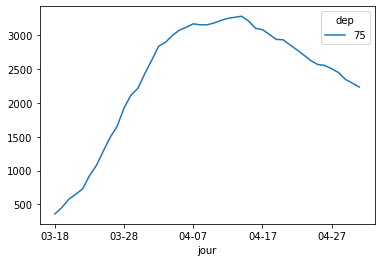

In [6]:
paris_data_pivot = paris_data_dep.pivot(index='jour', columns='dep', values='hosp')
paris_data_pivot.plot()

In [7]:
paris_data_cleaned = paris_data_dep[paris_data_dep['jour'] <= '04-07']

## Paris trafic

In [8]:
paris_trafic = pd.read_csv('paris_trafic_march.csv')
paris_trafic['jour'] = paris_trafic['day'].str.slice(start=5)
paris_trafic.head(1)

,Unnamed: 0,day,q,jour
0,341,2020-03-01,7732498.0,03-01


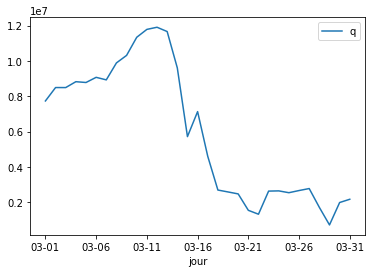

In [9]:
paris_trafic.plot(x='jour', y='q')

In [10]:
paris_trafic_cleaned = paris_trafic[paris_trafic['jour'] >= '03-11']
paris_trafic_cleaned.head(1)

,Unnamed: 0,day,q,jour
10,351,2020-03-11,11785624.0,03-11


## Prepare data

In [11]:
paris_data_cleaned['key'] = range(1, len(paris_data_cleaned) + 1)
paris_data_cleaned.head(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,dep,sexe,jour,hosp,rea,rad,dc,key
225,75,0,03-18,359,105,40,14,1


In [12]:
paris_trafic_cleaned['key'] = range(1, len(paris_trafic_cleaned) + 1)
paris_trafic_cleaned.head(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,day,q,jour,key
10,351,2020-03-11,11785624.0,03-11,1


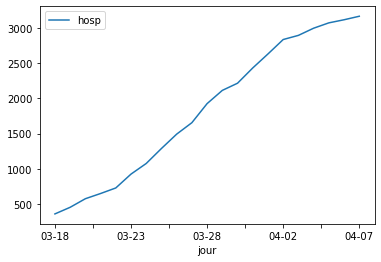

In [13]:
paris_data_cleaned.plot(x='jour', y='hosp')

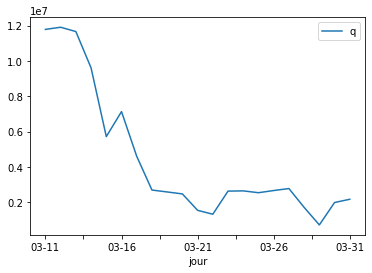

In [14]:
paris_trafic_cleaned.plot(x='jour', y='q')

In [15]:
merged = paris_trafic_cleaned.set_index('key').join(paris_data_cleaned.set_index('key'), lsuffix='_tf', rsuffix='_hp')
merged.head(1)

,Unnamed: 0,day,q,jour_tf,dep,sexe,jour_hp,hosp,rea,rad,dc
key,,,,,,,,,,,
1,351,2020-03-11,11785624.0,03-11,75,0,03-18,359,105,40,14


In [16]:
merged = merged[['jour_tf', 'hosp', 'q']]

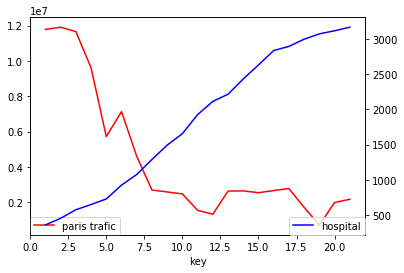

In [17]:
fig, ax = plt.subplots()
plt1 = merged.hosp.plot(ax=ax, style='b-', label='hospital', secondary_y=True)
plt2 = merged.q.plot(ax=ax, style='r-', label='paris trafic')
plt1.legend(loc='lower right', borderaxespad=0.)
plt2.legend(loc='lower left', borderaxespad=0.)

In [18]:
merged.corr()

,hosp,q
hosp,1.000000,-0.818124
q,-0.818124,1.000000


In [20]:
# create training and testing datasets
from sklearn.model_selection import train_test_split

x = merged[['q']]
y = merged.hosp
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=35)
print('Train dataset:', X_train.shape, y_train.shape)
print(' Test dataset:', X_test.shape, y_test.shape)

Train dataset: (16, 1) (16,)
 Test dataset: (5, 1) (5,)


## Create models

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

### Linear Regression

In [21]:
# fit a model
lin_reg = LinearRegression()
model1 = lin_reg.fit(X_train, y_train)

In [22]:
# predict on test dataset
predictions1 = lin_reg.predict(X_train)

In [23]:
# measure RSME
lin_mse = mean_squared_error(y_train, predictions1)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

600.0941144625556

### Decision Tree Regressor

In [24]:
# fit a model
tree_reg = DecisionTreeRegressor()
model2 = tree_reg.fit(X_train, y_train)

In [25]:
# predict on test dataset
predictions2 = tree_reg.predict(X_train)

In [26]:
# measure RSME
tree_mse = mean_squared_error(y_train, predictions2)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Random Forest Regressor

In [27]:
# fit a model
forest_reg = RandomForestRegressor()
model3 = forest_reg.fit(X_train, y_train)

In [28]:
# predict on test dataset
predictions3 = forest_reg.predict(X_train)

In [29]:
# measure RSME
forest_mse = mean_squared_error(y_train, predictions3)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

247.56140296399192

### Cross validation scores

In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [39]:
scores = cross_val_score(lin_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=2)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [907.84495372 861.40412527]
Mean: 884.6245394956001
Standard deviation: 23.220414228219624


In [40]:
scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=2)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [1270.35260853 1013.90963601]
Mean: 1142.1311222716981
Standard deviation: 128.22148625870517


In [42]:
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=2)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [1110.74620393  941.86119048]
Mean: 1026.3036972041818
Standard deviation: 84.44250672811165


## Fine-Tune the selected models

### Grid Search

In [43]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [1]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [1]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)
grid_search.best_params_
final_model = grid_search.best_estimator_

In [45]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

899.2190168572826 {'max_features': 1, 'n_estimators': 3}
1082.356557759503 {'max_features': 1, 'n_estimators': 10}
1014.1446523220113 {'max_features': 1, 'n_estimators': 30}
1149.3059862369116 {'bootstrap': False, 'max_features': 1, 'n_estimators': 3}
1149.3059862369116 {'bootstrap': False, 'max_features': 1, 'n_estimators': 10}


## Evaluate Your System on the Test Set

In [47]:
final_predictions = final_model.predict(X_test)

In [48]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

675.2816049619595

In [63]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
tmp = stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors))
#np.sqrt(tmp._0)
tmp

(-243625.18020975834, 1155635.6722097583)